## Brain Tumor Classification using ResNet50
This project implements a brain tumor classification model using the ResNet50 architecture. The dataset is processed, augmented, and used to train a deep learning model to classify brain tumors into multiple categories. The code includes data preprocessing, model building, training, fine-tuning, and evaluationز

##Importing Required Libraries

The following libraries are used for image processing, model building, data augmentation, and evaluation.

In [ ]:
import os
import cv2
import random
import numpy as np
from sklearn.utils import shuffle, class_weight
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras import regularizers

##Loading and Exploring the Dataset

This section loads the brain tumor dataset, defines class names, and maps them to numerical labels. It also loads a sample image to verify the data.

In [ ]:
class_names = [i for i in os.listdir('/content/drive/MyDrive/brain_tumor_dataset/Training')]
class_names_label = {j: i for i, j in enumerate(class_names)}
class_names_label

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2]]], dtype=uint8)
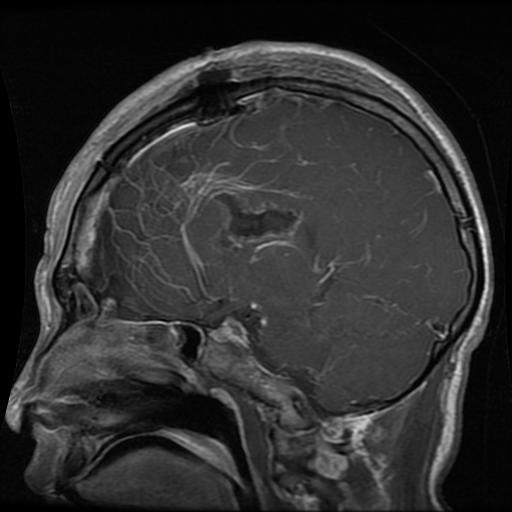

In [ ]:
ExampleImage = random.choice(os.listdir('/content/drive/MyDrive/brain_tumor_dataset/Training/glioma_tumor'))
ExampleImage = cv2.imread(os.path.join('/content/drive/MyDrive/brain_tumor_dataset/Training/glioma_tumor', ExampleImage))
ExampleImage

##Image Preprocessing

Images are resized to a consistent size (224x224) for compatibility with ResNet50. The dataset is loaded from training and testing directories, converted to RGB, and stored as NumPy arrays.

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [3, 3, 3],
        [3, 3, 3],
        [3, 3, 3]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [4, 4, 4],
        [4, 4, 4],
        [4, 4, 4]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2]]], dtype=uint8)
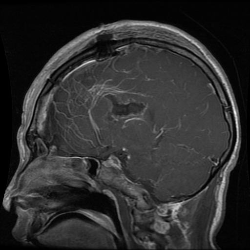

In [ ]:
cv2.resize(ExampleImage, (250, 250))

In [ ]:
Image_Size = (224, 224)

In [ ]:
datasets = ['/content/drive/MyDrive/brain_tumor_dataset/Training', '/content/drive/MyDrive/brain_tumor_dataset/Testing']
output = []
USE_GRAYSCALE = False
for dataset in datasets:
    images = []
    labels = []
    for folder in os.listdir(dataset):
        label = class_names_label[folder]
        for file in os.listdir(os.path.join(dataset, folder)):
            image_path = os.path.join(dataset, folder, file)
            if USE_GRAYSCALE:
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
            else:
                image = cv2.imread(image_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            if image is not None:
                image = cv2.resize(image, Image_Size)
                images.append(image)
                labels.append(label)
    images = np.array(images, dtype='float32')
    labels = np.array(labels, dtype='int32')
    output.append((images, labels))

##Data Splitting and Shuffling

The training data is shuffled and split into training and validation sets (85% training, 15% validation) with stratification to maintain class distribution.

In [ ]:
(X_train, y_train), (X_test, y_test) = output

In [ ]:
X_train, y_train = shuffle(X_train, y_train, random_state=44)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=44, stratify=y_train)

##Building the ResNet50 Model

A pre-trained ResNet50 model is used as the base, with custom layers added for classification. The base model is initially frozen to leverage pre-trained weights.

In [ ]:
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(len(class_names), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=x)

##Computing Class Weights

Class weights are computed to handle class imbalance, ensuring balanced training across all tumor types.

In [ ]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))

##Model Compilation and Data Augmentation

The model is compiled with the Adam optimizer, categorical crossentropy loss with label smoothing, and accuracy metrics. Data augmentation is applied to the training set to improve generalization.

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0003),loss=CategoricalCrossentropy(label_smoothing=0.1),metrics=['accuracy'])

In [ ]:
y_train_onehot = to_categorical(y_train, num_classes=len(class_names))
y_val_onehot = to_categorical(y_val, num_classes=len(class_names))
y_test_onehot = to_categorical(y_test, num_classes=len(class_names))

In [ ]:
train_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    zoom_range=0.15,
    shear_range=0.1,
    brightness_range=[0.9, 1.1],
    fill_mode='nearest'
)
val_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:
batch_size = 16
train_flow = train_generator.flow(X_train, y_train_onehot, batch_size=batch_size, shuffle=True)
val_flow = val_generator.flow(X_val, y_val_onehot, batch_size=batch_size, shuffle=False)
test_flow = test_generator.flow(X_test, y_test_onehot, batch_size=batch_size, shuffle=False)

##Training Callbacks

Early stopping and learning rate reduction callbacks are defined to prevent overfitting and optimize training.

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True
)

In [ ]:
lr_reduction = ReduceLROnPlateau(
    monitor='val_loss',
    patience=5,
    factor=0.3,
    min_lr=1e-7
)

##Initial Model Training

The model is trained for 30 epochs with data augmentation, class weights, and callbacks to monitor performance.

In [ ]:
history = model.fit(
    train_flow,
    epochs=30,
    validation_data=val_flow,
    callbacks=[early_stopping, lr_reduction],
    class_weight=class_weights_dict
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 64s 326ms/step - accuracy: 0.5552 - loss: 1.3230 - val_accuracy: 0.7912 - val_loss: 0.8101 - learning_rate: 3.0000e-04
Epoch 2/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 37s 242ms/step - accuracy: 0.7566 - loss: 0.9258 - val_accuracy: 0.8538 - val_loss: 0.7379 - learning_rate: 3.0000e-04
Epoch 3/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 36s 238ms/step - accuracy: 0.7742 - loss: 0.8771 - val_accuracy: 0.8631 - val_loss: 0.7454 - learning_rate: 3.0000e-04
Epoch 4/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 35s 230ms/step - accuracy: 0.7928 - loss: 0.8509 - val_accuracy: 0.8747 - val_loss: 0.7159 - learning_rate: 3.0000e-04
Epoch 5/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 37s 239ms/step - accuracy: 0.8296 - loss: 0.7887 - val_accuracy: 0.8817 - val_loss: 0.6899 - learning_rate: 3.0000e-04
Epoch 6/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 36s 238ms/step - accuracy: 0.8375 - loss: 0.7602 - val_accuracy: 0.8910 - val_loss: 0.6704 - learning_rate: 3.0000e-04
Epoch 7/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 36s 23

In [ ]:
test_loss, test_accuracy = model.evaluate(test_flow)
print(f'Test accuracy after initial training: {test_accuracy:.4f}')

25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 175ms/step - accuracy: 0.5670 - loss: 1.5308
Test accuracy after initial training: 0.7538


##Fine-Tuning the Model

The last 50 layers of the ResNet50 base model are unfrozen for fine-tuning with a lower learning rate to improve performance.

In [ ]:
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

In [ ]:
model.compile(optimizer=Adam(learning_rate=1e-5), loss=CategoricalCrossentropy(label_smoothing=0.1),metrics=['accuracy'])

In [ ]:
history_finetune = model.fit(
    train_flow,
    epochs=20,
    validation_data=val_flow,
    callbacks=[early_stopping, lr_reduction],
    class_weight=class_weights_dict
)

Epoch 1/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 82s 371ms/step - accuracy: 0.8952 - loss: 0.6522 - val_accuracy: 0.9211 - val_loss: 0.6178 - learning_rate: 1.0000e-05
Epoch 2/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 37s 239ms/step - accuracy: 0.9251 - loss: 0.6280 - val_accuracy: 0.9281 - val_loss: 0.6174 - learning_rate: 1.0000e-05
Epoch 3/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 38s 248ms/step - accuracy: 0.9430 - loss: 0.5947 - val_accuracy: 0.9374 - val_loss: 0.6102 - learning_rate: 1.0000e-05
Epoch 4/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 39s 256ms/step - accuracy: 0.9341 - loss: 0.6100 - val_accuracy: 0.9374 - val_loss: 0.6109 - learning_rate: 1.0000e-05
Epoch 5/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 38s 247ms/step - accuracy: 0.9418 - loss: 0.5827 - val_accuracy: 0.9443 - val_loss: 0.5956 - learning_rate: 1.0000e-05
Epoch 6/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 37s 244ms/step - accuracy: 0.9487 - loss: 0.5801 - val_accuracy: 0.9350 - val_loss: 0.5963 - learning_rate: 1.0000e-05
Epoch 7/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 38s 24

In [ ]:
test_loss, test_accuracy = model.evaluate(test_flow)
print(f'Test accuracy after fine-tuning: {test_accuracy:.4f}')

25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 0.6333 - loss: 1.4896
Test accuracy after fine-tuning: 0.8096


##Final Training with Ultra-Low Learning Rate

A final training pass with an ultra-low learning rate is performed to refine the model further.

In [ ]:
model.compile(optimizer=Adam(learning_rate=1e-6),loss=CategoricalCrossentropy(label_smoothing=0.1),metrics=['accuracy'])

In [ ]:
history_final = model.fit(
    train_flow,
    epochs=5,
    validation_data=val_flow,
    class_weight=class_weights_dict
)

Epoch 1/5
153/153 ━━━━━━━━━━━━━━━━━━━━ 84s 391ms/step - accuracy: 0.9836 - loss: 0.5180 - val_accuracy: 0.9675 - val_loss: 0.5446
Epoch 2/5
153/153 ━━━━━━━━━━━━━━━━━━━━ 39s 253ms/step - accuracy: 0.9816 - loss: 0.5127 - val_accuracy: 0.9606 - val_loss: 0.5459
Epoch 3/5
153/153 ━━━━━━━━━━━━━━━━━━━━ 37s 245ms/step - accuracy: 0.9819 - loss: 0.5112 - val_accuracy: 0.9629 - val_loss: 0.5467
Epoch 4/5
153/153 ━━━━━━━━━━━━━━━━━━━━ 42s 249ms/step - accuracy: 0.9829 - loss: 0.5189 - val_accuracy: 0.9606 - val_loss: 0.5453
Epoch 5/5
153/153 ━━━━━━━━━━━━━━━━━━━━ 37s 244ms/step - accuracy: 0.9806 - loss: 0.5222 - val_accuracy: 0.9629 - val_loss: 0.5462


In [ ]:
test_loss, test_accuracy = model.evaluate(test_flow)
print(f'Test accuracy after final ultra-low LR pass: {test_accuracy:.4f}')

25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 0.6302 - loss: 1.4888
Test accuracy after final ultra-low LR pass: 0.8122


##Saving the Model

The trained model is saved in both .h5 and .keras formats for future use.

In [ ]:
model.save("my_model.h5")

In [ ]:
model.save('my_model.keras')

##Results

The model was trained in three phases:





Initial Training (30 epochs): Achieved a test accuracy of 0.7538.



Fine-Tuning (20 epochs): Improved test accuracy to 0.8096.



Final Training (5 epochs with ultra-low LR): Further improved test accuracy to 0.8122.

The training logs show consistent improvement in validation accuracy, peaking at 0.9675 in the final phase, with a validation loss of 0.5446. The use of data augmentation, class weights, and fine-tuning helped address class imbalance and improved generalization.